# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [41]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

# Libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [42]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

## Loader les fichiers .csv

In [43]:
# Load the .csv files
X_train = pd.read_csv('Data/X_train.csv', sep='\t')
X_test = pd.read_csv('Data/X_test.csv', sep='\t')
y_train = pd.read_csv('Data/y_train.csv', sep='\t')
y_test = pd.read_csv('Data/y_test.csv', sep='\t')

In [44]:
# Check the loaded files
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 9843 observations et 3 features.
Le vecteur y_train contient 9842 observations.
Le jeu de données X_test contient 9844 observations et 3 features.
Le vecteur y_test contient 9843 observations.


## Récupérer les arrays

### Bag of words !!! Utilité ???

### TF-IDF

In [9]:
# Load the arrays 
X_train_tfidf = np.load('Data/X_train_tfidf.npy')
X_train_vocab_tfidf = np.load('Data/X_train_vocab_tfidf.npy')
X_train_dist_tfidf = np.load('Data/X_train_dist_tfidf.npy')
y_train_tfidf = np.load('Data/y_train_tfidf.npy')
y_train_vocab_tfidf = np.load('Data/y_train_vocab_tfidf.npy')
y_train_dist_tfidf = np.load('Data/y_train_dist_tfidf.npy')
X_train_title_tfidf = np.load('Data/X_train_title_tfidf.npy')
X_train_title_vocab_tfidf = np.load('Data/X_train_title_vocab_tfidf.npy')
X_train_title_dist_tfidf = np.load('Data/X_train_title_dist_tfidf.npy')

In [45]:
# Check the loaded arrays
X_train_tfidf.shape

(9843, 5000)

# Modélisation de flags basée sur les fréquences

## Fréquences BOW

Nous allons mettre en oeuvre une méthode basée uniquement sur les fréquences des expressions (mot / bigram) utilisées dans le post et nous allons regarder si les expressions les plus fréquentes apparaissent dans le vocabulaire de tags.

Tout d'abord, nous allons analyser s'il existe un ou plusieurs expressions, présentes au moins deux fois dans chaque post, qui matchent avec le vocabulaire de tags. 

Nous allons utiliser la décomposition en Bag of words créé dans le notebook1, chapître 6.1.2 :

In [ ]:
#The tags vocabulary :
y_train_vocab_bow[:10]

In [ ]:
#The features vocabulary : 
X_train_vocab_bow[:10]

In [ ]:
#The BOW array :
X_train_bow[:10]

### Tester les fonctions sur le premier post

Nous allons tester notre idée sur le premier post.

In [ ]:
BOW_post1 = X_train_bow[0]
BOW_post1

In [ ]:
#We print all expressions which are at least 2 times in the post :
for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        print (freq, word)

In [ ]:
#We compare the frequent expression to the tag's vocab:

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            print(word)

In [ ]:
predicted_tags_vect = []

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            predicted_tags_vect.append(word)

predicted_tags_vect

### Création d'une fonction à appliquer sur toutes les données

In [ ]:
Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [ ]:
def pred_tag_freq(BOW, vocabulary, list_of_tags):
    
    """Function which generates a list of tags, based on frequency of expression in a BOW object and 
    its comparison to predefined list of tags.
    
    Input :
    - BOW : a BOW array
    - vocabulary : list of BOW vocabulary
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for vect in range(BOW.shape[0]): 
        
        predicted_tags_vect = [] 
        
        for freq, word in zip(BOW[vect], vocabulary):
            
            if freq >= 2:
                if word in list_of_tags:
                    predicted_tags_vect.append(word)
                    
        predicted_tags.append(predicted_tags_vect)
        
    return predicted_tags

In [ ]:
predicted_tags = pred_tag_freq(X_train_bow, X_train_vocab_bow, y_train_vocab_bow)

In [ ]:
len(predicted_tags)

In [ ]:
predicted_tags[:10]

In [ ]:
Sauvegarder les tags prédits:

In [ ]:
#Save the predicted tags:
np.save('Data/predicted_tags', predicted_tags)

Nous allons analyser le nombre de tag prédits par la méthode :

In [ ]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [ ]:
nbr_tags[0].value_counts()

Désavantage de la méthode : nous avons des posts sans tag attribué (1875 posts) et certains posts peuvent avoir un grand nombre de tags, même si c'est plutôt rare. Nous allons appliquer la même méthode avec TF-IDF et choisir 3 tags les plus fréquents basé sur le coefficient TF-IDF. 

## Fréquences TF-IDF

L'idée est d'utiliser les fréquences TF-IDF pour avoir la main sur le nombre de tags à prédire. Cette fois-ci, la méthode sera basé sur la procédure suivante :

1. Nous allons comparer toutes les expressions dans le post avec le vocabulaire de tags
2. Nous allons attribuer à chaque expression la distance relative TF-IDF de tag
3. Nous allons sortir 3 tags les plus fréquents

In [147]:
y_train_dist_tfidf[:10]

array([1.29137083e+00, 2.03157824e+01, 1.77910765e+00, 1.23469745e+03,
       7.61972597e-01, 1.03923973e+01, 1.00032151e+02, 5.74763060e+00,
       1.16193175e+02, 2.80201636e+00])

### Tester les fonctions sur le premier post

In [148]:
#Extract the array of first post
TFIDF_post1 = X_train_tfidf[0]
TFIDF_post1

array([0., 0., 0., ..., 0., 0., 0.])

In [149]:
#We compare the expressions in the post to the tag's vocab:
for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            print(word)

add
authentication
handle
permissions
plugins
restful-authentication
role
using


In [175]:
#We list the common expressions which are in both document and the tag's vocabulary:

liste_tags = []

for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            liste_tags.append(word)

In [176]:
liste_tags

['add',
 'authentication',
 'handle',
 'permissions',
 'plugins',
 'restful-authentication',
 'role',
 'using']

In [177]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

1.2913708286761647 add
20.315782399608562 authentication
1.779107648085159 handle
1234.6974528795652 permissions
0.7619725969000765 plugins
10.392397318668808 restful-authentication
100.03215112054504 role
5.747630599165471 using


In [178]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [180]:
#Converting to list
liste = list(liste)

In [181]:
#Check
liste

[(1.2913708286761647, 'add'),
 (20.315782399608562, 'authentication'),
 (1.779107648085159, 'handle'),
 (1234.6974528795652, 'permissions'),
 (0.7619725969000765, 'plugins'),
 (10.392397318668808, 'restful-authentication'),
 (100.03215112054504, 'role'),
 (5.747630599165471, 'using')]

In [185]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [186]:
#Check
liste_sort

[(0.7619725969000765, 'plugins'),
 (1.2913708286761647, 'add'),
 (1.779107648085159, 'handle'),
 (5.747630599165471, 'using'),
 (10.392397318668808, 'restful-authentication'),
 (20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [193]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [194]:
tags_final

[(20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [195]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [196]:
tags

['authentication', 'role', 'permissions']

### Appliquer la fonctions sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [198]:
# At first, we will test the function on a sample
test_sample = X_train_tfidf[:100]

In [199]:
test_sample.shape

(100, 50000)

In [200]:
def pred_tag_tfidf(tfidf_array, tfidf_vocabulary, list_of_tags):
    
    """Function generatig a list of tags, based on frequency of expression in an TF-IDF object and 
    its comparison to predefined list of tags. 
    
    Is the document contains more than 3 common expressions with the list of tags, the tags are sorted by the 
    TF-IDF frequency and only 3 most common tags are the predicted tags. If the document contains 
    2 or less common expressions, all the expressions are considered comme predicted tags. 
        
    Input :
    - tfidf_array : a TF-IDF array
    - tfidf_vocabulary : a TF-IDF vocabulary object
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for doc in range(tfidf_array.shape[0]): 
       
        #We list the common expressions which are in both document and the tag's vocabulary:   
    
        liste_tags = []

        for freq, word in zip(tfidf_array[doc], tfidf_vocabulary):
            if freq > 0:
                if word in list_of_tags:
                    liste_tags.append(word)
                    
        
    
    predicted_tags.append(liste_tags)
    
    return predicted_tags

In [201]:
# !!! Regarder la fct précédente, le même pb. Indentation ???
pred_tag_tfidf(test_sample, X_train_vocab_tfidf, y_train_vocab_tfidf)

[['c#', 'file', 'fixed', 'fixed-width', 'width']]

In [177]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

1.2913708286761647 add
20.315782399608562 authentication
1.779107648085159 handle
1234.6974528795652 permissions
0.7619725969000765 plugins
10.392397318668808 restful-authentication
100.03215112054504 role
5.747630599165471 using


In [178]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [180]:
#Converting to list
liste = list(liste)

In [181]:
#Check
liste

[(1.2913708286761647, 'add'),
 (20.315782399608562, 'authentication'),
 (1.779107648085159, 'handle'),
 (1234.6974528795652, 'permissions'),
 (0.7619725969000765, 'plugins'),
 (10.392397318668808, 'restful-authentication'),
 (100.03215112054504, 'role'),
 (5.747630599165471, 'using')]

In [185]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [186]:
#Check
liste_sort

[(0.7619725969000765, 'plugins'),
 (1.2913708286761647, 'add'),
 (1.779107648085159, 'handle'),
 (5.747630599165471, 'using'),
 (10.392397318668808, 'restful-authentication'),
 (20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [193]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [194]:
tags_final

[(20.315782399608562, 'authentication'),
 (100.03215112054504, 'role'),
 (1234.6974528795652, 'permissions')]

In [195]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [196]:
tags

['authentication', 'role', 'permissions']

# Modélisation non supervisée

## LDA

In [9]:
print ("Number of unique tags: %d" % len(y_train_vocab_tfidf))

Number of unique tags: 4998


Nous allons faire LDA afin de trouver des sujets de posts. Etant donné que nous avons un grand nombre de tags uniques (~5k), nous allons réformuler les tags existants à l'aide de mots clés caractéristiques pour chaque sujet. 

Nous allons essayer de trouver un nombre de sujets optimal, pour que les sujets soient interprétables.

### Document = titre + body + bigrams

In [31]:
# First training of LDA : 20 topics
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [32]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
kill file-txt subprocess progress-bar process progress killed kill-9 file bar
Topic 1
column panda dataframe df 00 row nan pd column-name 00-00
Topic 2
docker container docker-container image compose backup docker-compose observable volume docker-image
Topic 3
predicate given-name found-match match-given semantic 'android resource-found 21) attr-'android name-attr
Topic 4
file string like code get function difference data value python
Topic 5
gem usr 1-2 2-3 py ruby bin 3-4 1-1 4-5
Topic 6
tf notepad++ character word lf random looking-something embedded equivalent pre
Topic 7
notification locale push-notification america expect( africa asia europe pacific time-option
Topic 8
pip install package pip-install virtualenv conda install-package easy-install pypi package-pip
Topic 9
ssh +-+ sublime fork sublime-text markdown batch batch-file permission denied
Topic 10
android div image cs width view color height button text
Topic 11
intellij singleton intellij-idea way-implement patte

In [33]:
# Second LDA training : 15 topics
no_topics = 15

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [34]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
'28 '28-aug aug oracle 68 cd 49 54 81 (3
Topic 1
intellij intellij-idea permanently that's line-number attach enable ctrl debugger bad
Topic 2
edittext validation dynamic move c++11 z lambda anonymous error index
Topic 3
option option-value option-option option-select standard-time time-option (gmt value-america value-asia utc-+
Topic 4
file string like code difference get function class java data
Topic 5
git branch commit repository file github remote master docker directory
Topic 6
table sql mysql database column query sql-server row postgresql select
Topic 7
android activity layout fragment android-layout intent textview color view hidden-feature
Topic 8
npm node panda column gem dataframe usr install node-j j
Topic 9
utf utf-8 unicode long-line ci initandlisten 5t 0-00 00-0 03-03
Topic 10
font latitude longitude latitude-longitude custom-font lat sdl america africa asia
Topic 11
webclient httpwebrequest asynchronously 901) system-err( err(-901) err( w-system mainactivity ne

Nous pouvons voir que certains sujets sont difficile à interpréter : Nous allons entraîner le modèle à nouveau, cette fois-ci avec 10 sujets. Nous allons aussi réduire le nombre d'expressions clés dans l'affichage, nous allons regarder seulement 5 premiers mots.

In [35]:
# 3rd LDA training : 10 topics
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)

In [36]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
docker container hidden-feature hidden export feature docker-container compose docker-compose export-default
Topic 1
file android command error directory python install java script package
Topic 2
nan utf utf-8 collation 153 103 '28 '28-aug aug unicode
Topic 3
sublime sublime-text decimal round decimal-place place lowercase 901) err(-901) system-err(
Topic 4
position) wagon 46 57 1024 feeling 66 typename opt throw-new
Topic 5
string like code difference function class get file value data
Topic 6
git branch commit repository github master remote file push commits
Topic 7
panda dataframe column join 00 df intellij latitude longitude 'b'
Topic 8
div width height margin div-div center div-class padding div-id 100%
Topic 9
progress-bar travelguard com-travelguard travelguard-ui user-david david-developer generating-source file-com note-generating ui-fragment


In [37]:
# 4th LDA training : 5 topics
no_topics = 5

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_tfidf)

In [38]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
git branch commit repository github remote master push merge file
Topic 1
div image cs color width height text view button element
Topic 2
bean blah export clipboard comprehension export-default list-comprehension groupid artifactid blah-blah
Topic 3
file string like code difference get function python data java
Topic 4
android activity fragment layout certificate android-layout gradle android-studio intent apk


In [39]:
# 4th LDA training : 3 topics
no_topics = 3

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_tfidf)

In [40]:
# Display 10 top words

display_topics(lda, X_train_vocab_tfidf, no_top_words)

Topic 0
android image div text cs button color view width jquery
Topic 1
file git command branch directory project version repository commit install
Topic 2
string difference like code function java data get value class


Même en modifiant les paramètres, nous n'avons pas trouvé des sujets faciles à interpréter et à reformuler. Nous allons essayer de changer la forme de "document" qui rentre dans le modèle. Nous allons cette fois-ci étudier uniquement le titre de text sans bigrams.

### Document = titre

In [22]:
# First training of LDA : 20 topics
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_title_tfidf)

In [23]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
net c# json string type java mvc asp xml reference
Topic 1
object django field javascript custom copy every collection mongodb log
Topic 2
cs browser rail detect div current content size inside page
Topic 3
image docker background save container wpf tab active recyclerview reading
Topic 4
color memory button bootstrap form font start multi header add
Topic 5
sql server table vim package mysql install database case master
Topic 6
git difference branch repository commit query remote thread time merge
Topic 7
mean ruby array iphone link pointer exactly passing keyword display
Topic 8
matplotlib cmake complete distance flag selection prefix longitude latitude floating
Topic 9
request http post programmatically jquery language algorithm setting location android
Topic 10
j application app node android return google framework open test
Topic 11
programming pattern design library template debug client export rule iterate
Topic 12
php variable pas feature email hidden session dynamic pr

In [26]:
# Second LDA training : 10 topics
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_title_tfidf)

In [27]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
sql server table database mysql test algorithm output language getting
Topic 1
operator fragment build duplicate xcode debug version place gradle tool
Topic 2
loop rail framework entity map nested inside auto real regex
Topic 3
string column image swift docker panda background character specific spring
Topic 4
programming pattern design delete memory join index center understanding update
Topic 5
vim text install package tag o search space mac case
Topic 6
java difference python object javascript list variable class what's string
Topic 7
git file branch repository directory commit read remote command github
Topic 8
android net php file request http io j asp get
Topic 9
jquery element javascript function array event iphone html bootstrap mean


In [29]:
# Second LDA training : 5 topics
no_topics = 5

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=100., 
                                random_state=0).fit(X_train_title_tfidf)

In [30]:
no_top_words = 10

display_topics(lda, X_train_title_vocab_tfidf, no_top_words)

Topic 0
difference what's net java android application c service asp mvc
Topic 1
php api page android iphone io app memory programmatically detect
Topic 2
string mean rail call delete test method current function date
Topic 3
sql j mysql table html string server column node request
Topic 4
git file array python javascript list command object get multiple


## Clustering avec TF-IDF et KMeans

Nous allons utiliser MiniBatchKmeans pour créer des groupes de posts. Les clusters seront ensuite visualisés à l'aide d ACP et t-SNE.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


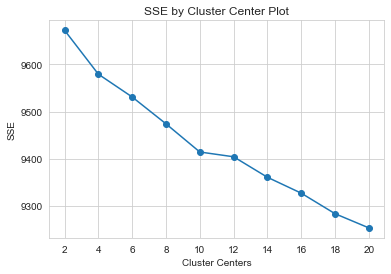

In [46]:
# Code de kaggle


def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_train_tfidf, 20)

In [47]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_train_tfidf)

In [49]:
# Code Kaggle

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

NameError: name 'cm' is not defined

In [52]:
# Code Kaggle

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [53]:
silhouette = []
k = list(range(2, 20))

In [57]:
from sklearn.metrics import silhouette_score

In [58]:
for i in k:
    kmeans = MiniBatchKMeans(n_clusters=i, init_size=1024, batch_size=2048, random_state=20)
    y_pred = kmeans.fit_predict(X_train_tfidf)
    score = silhouette_score(X_train_tfidf, kmeans.labels_)
    silhouette.append(score)

In [59]:
silhouette

[0.0038936426380027527,
 0.0049591212350076855,
 0.006953279537161638,
 0.006556147295863951,
 0.007409674775021158,
 0.008144181332474711,
 0.008561547153474017,
 0.008529269139652679,
 0.01073892067897662,
 0.00946012827726556,
 0.010180319724362985,
 0.010179931445086686,
 0.011061551278216048,
 0.01025787943421668,
 0.010677186744877911,
 0.010697581106175719,
 0.01124060309017022,
 0.011759669330787089]

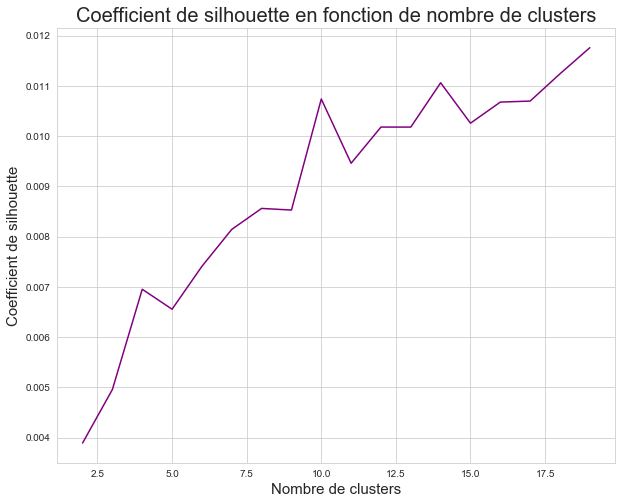

In [60]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Nombre de clusters', fontsize=15)
ax.set_ylabel('Coefficient de silhouette', fontsize=15)
ax.set_title(
    'Coefficient de silhouette en fonction de nombre de clusters', fontsize=20)

plt.plot(k, silhouette, color="purple")

Nous allons choisir 10 clusters :

In [61]:
kmeans = MiniBatchKMeans(n_clusters=10, init_size=1024, batch_size=2048, random_state=20)
y_pred = kmeans.fit_predict(X_train_tfidf)

In [64]:
y_pred = DataFrame(y_pred)
y_pred.rename({0: 'Cluster'}, axis=1, inplace=True)

In [62]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_tfidf)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])

In [67]:
principalDf = principalDf.merge(y_pred, left_index=True, right_index=True)

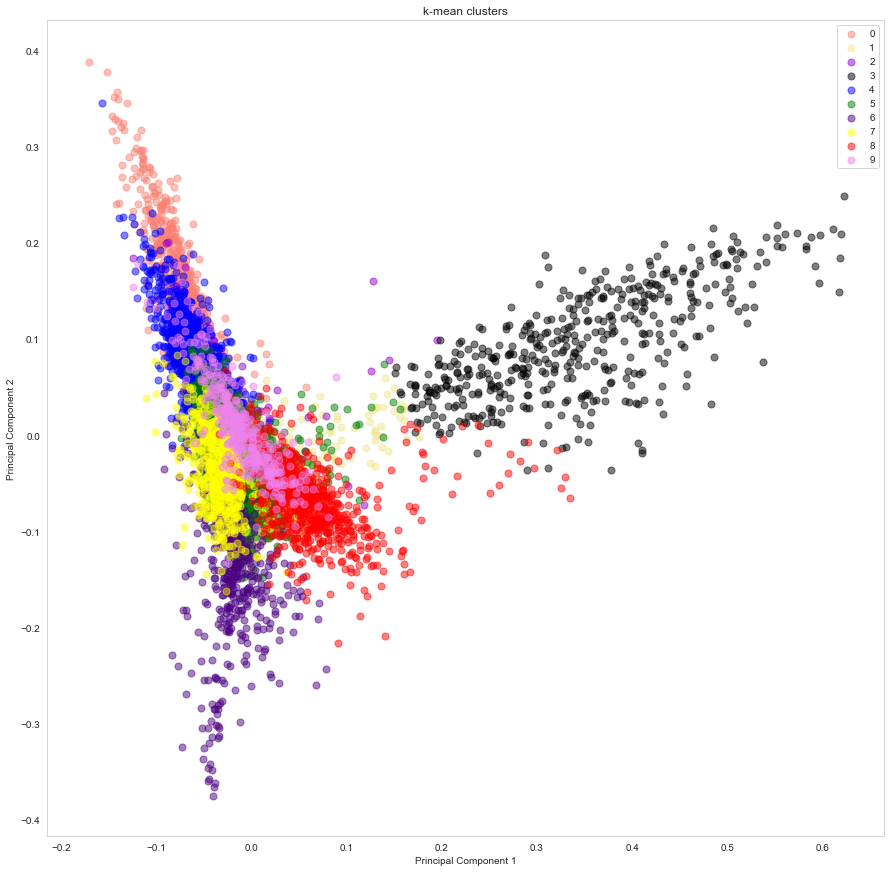

In [69]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('k-mean clusters', fontsize=12)

targets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['salmon', 'khaki', 'darkviolet', 'black', 'blue', 'green', 'indigo', 'yellow', 'red', 'violet']
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['Cluster'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
ax.legend(targets)
ax.grid()

t-SNE

In [71]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(X_train_tfidf)

principalDf = pd.DataFrame(data=tsne_df, columns=[
                           'principal component 1', 'principal component 2'])

In [72]:
principalDf = principalDf.merge(y_pred, left_index=True, right_index=True)

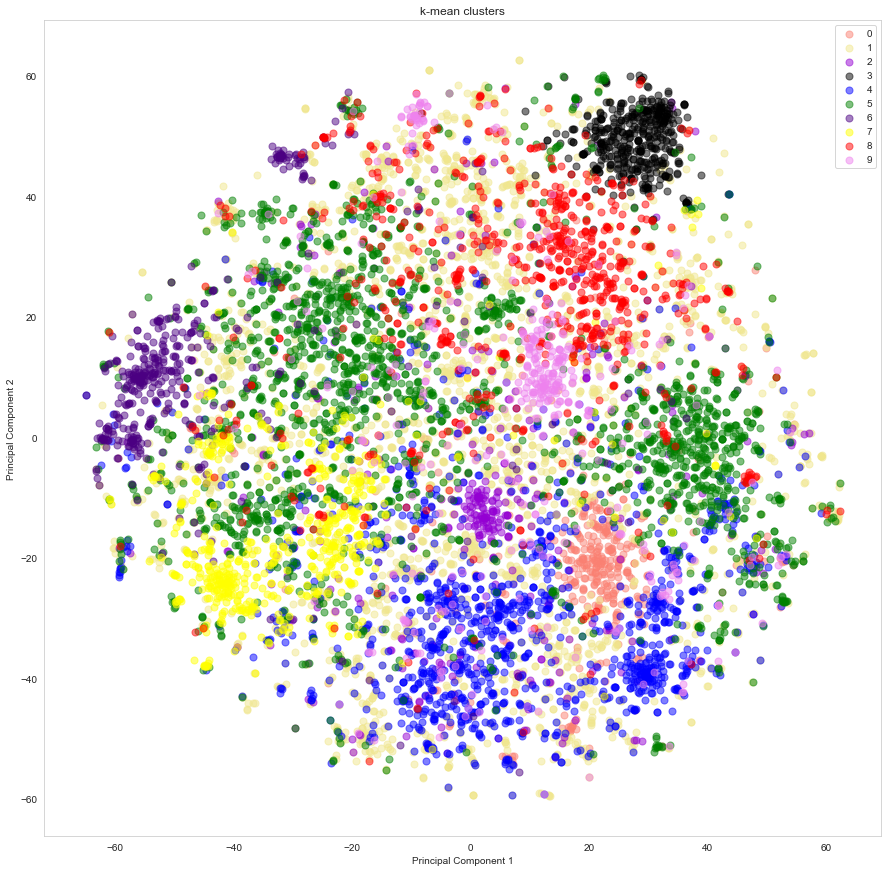

In [73]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('k-mean clusters', fontsize=12)

targets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
colors = ['salmon', 'khaki', 'darkviolet', 'black', 'blue', 'green', 'indigo', 'yellow', 'red', 'violet']
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['Cluster'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
ax.legend(targets)
ax.grid()

# Modélisation supervisée

## KNN + word2vect

In [ ]:
# !!! A tester
# model = Word2Vec.load("300features_40minwords_10context")